In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation #necessite ffmpeg pour enregistrer les animations
from estimation import*
% matplotlib inline

# Introduction

Ce notebook vise à présenter la génération de TVAR à partir des racines du polynôme associé. On étudiera aussi l'influence des phases des racines sur la densité spectrale de puissance

In [2]:
# bruit utilise dans tout le notebook
epsilon = np.random.randn(int(2e4))

# Exemple du TVAR(1)
Le polynôme est $1 - a(u)z$. 
$a(u)$ étant l'inverse de la racine. On prend $a(u)=\rho(u) e^{i\phi(u)}$

## Cas où $\phi$ est constant

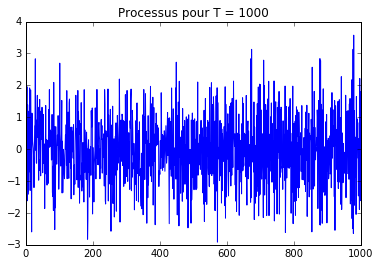

In [3]:
T = 1000
X = np.zeros(2*T, dtype='complex')
a = np.zeros(2*T, dtype='complex')

u = np.arange(T, dtype='double')/T

rho = 1-np.exp(-u)
phase = 0.5
phi = 2.*np.pi*phase

a[T:2*T] = rho*np.exp(1j*phi)

X[0] = epsilon[0]
    
for n in np.arange(2*T-1):
    X[n+1] = a[n+1]*X[n] + epsilon[n+1]
    
t = np.arange(2*T) - T #horizon des temps

plt.plot(t[T:2*T], np.real(X[T:2*T]))
plt.title("Processus pour T = 1000")

### Analyse spectrale théorique :

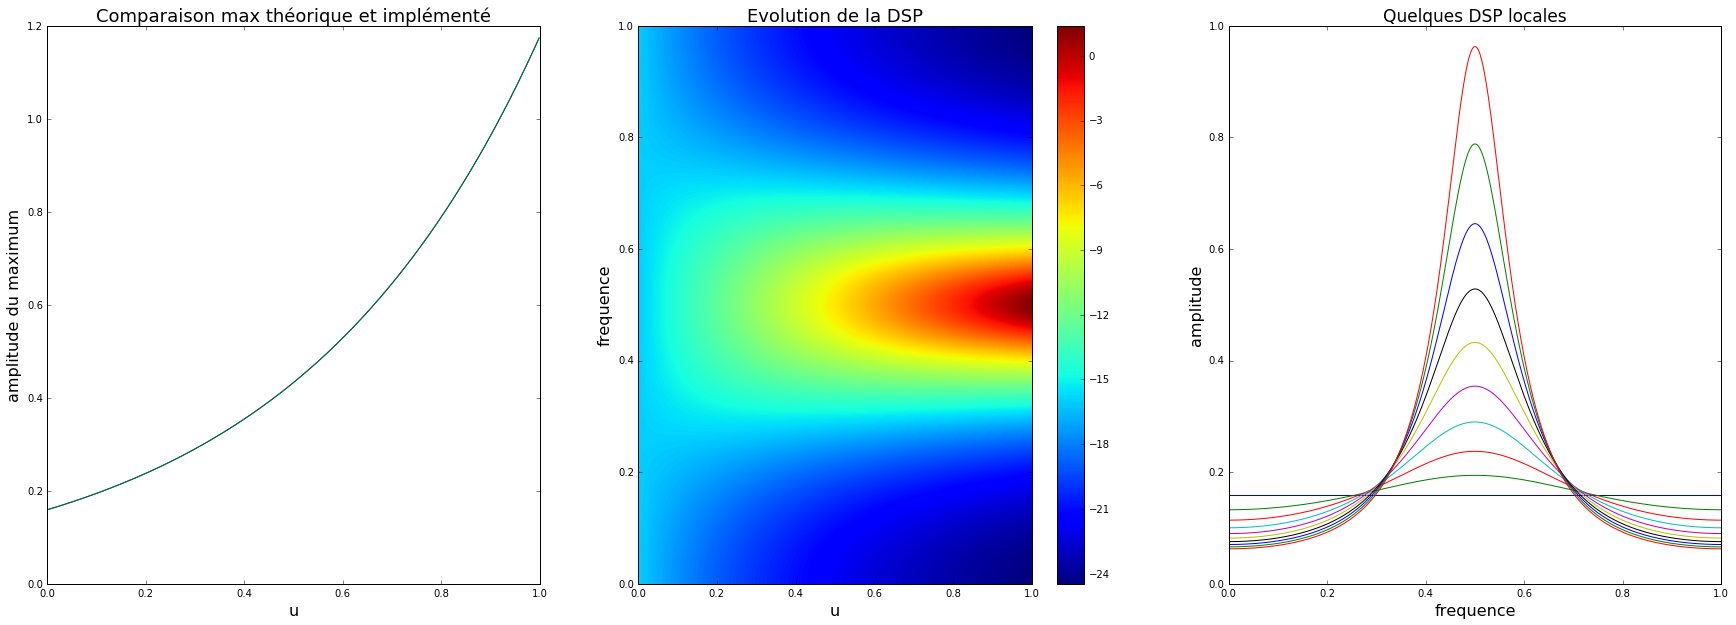

In [4]:
# Analyse spectrale théorique
Nfft = 2**10
Theta = np.concatenate((np.ones((1,T),dtype='complex'),-a[T:2*T].reshape(1,T)),axis=0)
freq, dsp_array = dsp(Theta,T,Nfft)

freq = freq.reshape(Nfft,1)

max_val = np.zeros(T)
for t in np.arange(T):
    max_val[t] = np.max(dsp_array[:,t])
    
    
fig,ax = plt.subplots(1,3,figsize=(30,10))
fsize=16
ax[0].plot(u, max_val)
ax[0].plot(u, 1./(2*np.pi*(1-rho)**2))
ax[0].set_xlabel("u",fontsize=fsize)
ax[0].set_ylabel("amplitude du maximum",fontsize=fsize)
ax[0].set_title("Comparaison max théorique et implémenté",fontsize=fsize+2)

im=ax[1].imshow(20*np.log10(dsp_array),origin="lower", aspect="auto",extent=[0,1,0,1])
plt.colorbar(im,ax=ax[1])
ax[1].set_xlabel("u",fontsize=fsize)
ax[1].set_ylabel("frequence",fontsize=fsize)
ax[1].set_title("Evolution de la DSP",fontsize=fsize+2)

ax[2].plot(freq, dsp_array[:,0::100])
ax[2].set_xlabel("frequence",fontsize=fsize)
ax[2].set_ylabel("amplitude",fontsize=fsize)
ax[2].set_title("Quelques DSP locales",fontsize=fsize+1)

plt.show()

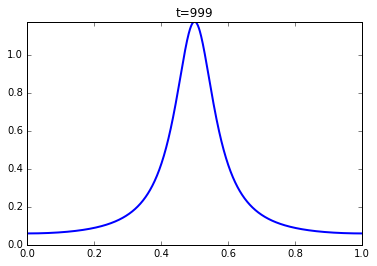

In [5]:
### Animation 
# Definition de la figure et des axes
fig = plt.figure()
ax = plt.axes(xlim=(0,1), ylim = (0,np.max(dsp_array)))
line, = ax.plot([], [], lw=2)
max_theo, = ax.plot([],[],'r--',lw=1) 
maximum, = ax.plot([],[],'g--',lw=1) 


# Fonction d'initialisation : affiche le fond à chaque étape
def init():
    line.set_data([], [])
    max_theo.set_data([],[])
    maximum.set_data([],[])
    return line, max_theo, maximum

# Fonction d'animation
def animate(t):
    line.set_data(freq, dsp_array[:,t])
    max_theo_val = 1./(2*np.pi*(1-rho[t])**2)
    max_theo.set_data([0,1],[max_theo_val,max_theo_val])  
    maximum.set_data([0,1],[max_val[t],max_val[t]])    
    ax.set_title("t=%d"%t)
    return line, max_theo, maximum

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=T, interval=1, blit=True)

anim.save('TVAR1_racine_module.mp4',fps=150,extra_args=['-vcodec', 'libx264'])

### Estimation :

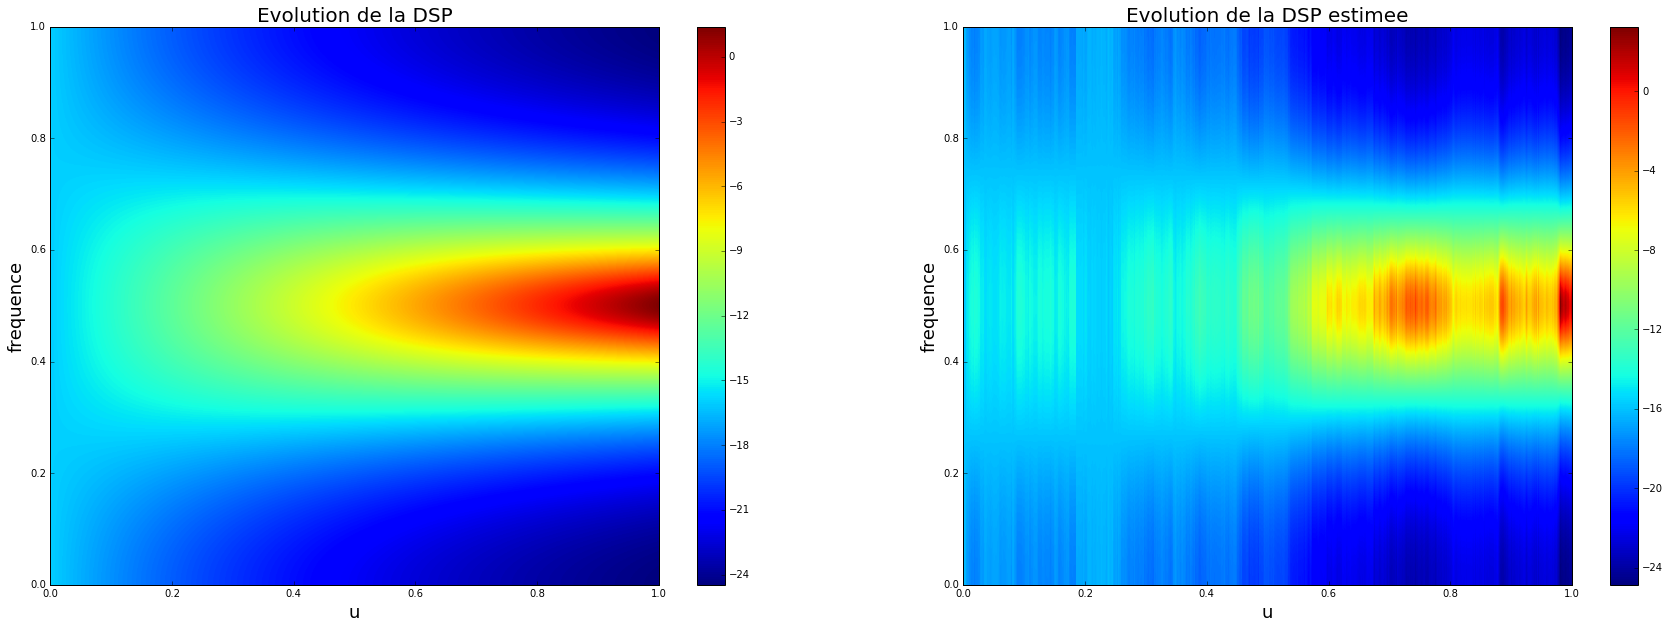

In [6]:
d=1
mu = 0.01
_, theta_est = generation_est2(X[T:2*T], d, T, mu)

coeffs_est = np.ones((d+1,T),dtype='complex')
coeffs_est[1:,:] = -theta_est 

f, dsp_X_est = dsp(coeffs_est, T, Nfft)

fig,ax = plt.subplots(1,2,figsize=(30,10))
fsize=18
im=ax[0].imshow(20*np.log10(dsp_array),origin="lower", aspect="auto",extent=[0,1,0,1])
plt.colorbar(im,ax=ax[0])
ax[0].set_xlabel("u",fontsize=fsize)
ax[0].set_ylabel("frequence",fontsize=fsize)
ax[0].set_title("Evolution de la DSP",fontsize=fsize+2)

im2=ax[1].imshow(20*np.log10(dsp_X_est),origin="lower", aspect="auto",extent=[0,1,0,1])
plt.colorbar(im2,ax=ax[1])
ax[1].set_xlabel("u",fontsize=fsize)
ax[1].set_ylabel("frequence",fontsize=fsize)
ax[1].set_title("Evolution de la DSP estimee",fontsize=fsize+2)

plt.show()


#### Agrégation

In [8]:
log_mu = np.arange(-3, -2, 0.1)
N = len(log_mu)
mu = np.power(10, log_mu)

pred, estim,_ = do_aggregation(X[T:2*T],d,T, 0.1, mu,1)
pred2, estim2,_ = do_aggregation(X[T:2*T], d, T, 0.1, mu,2)

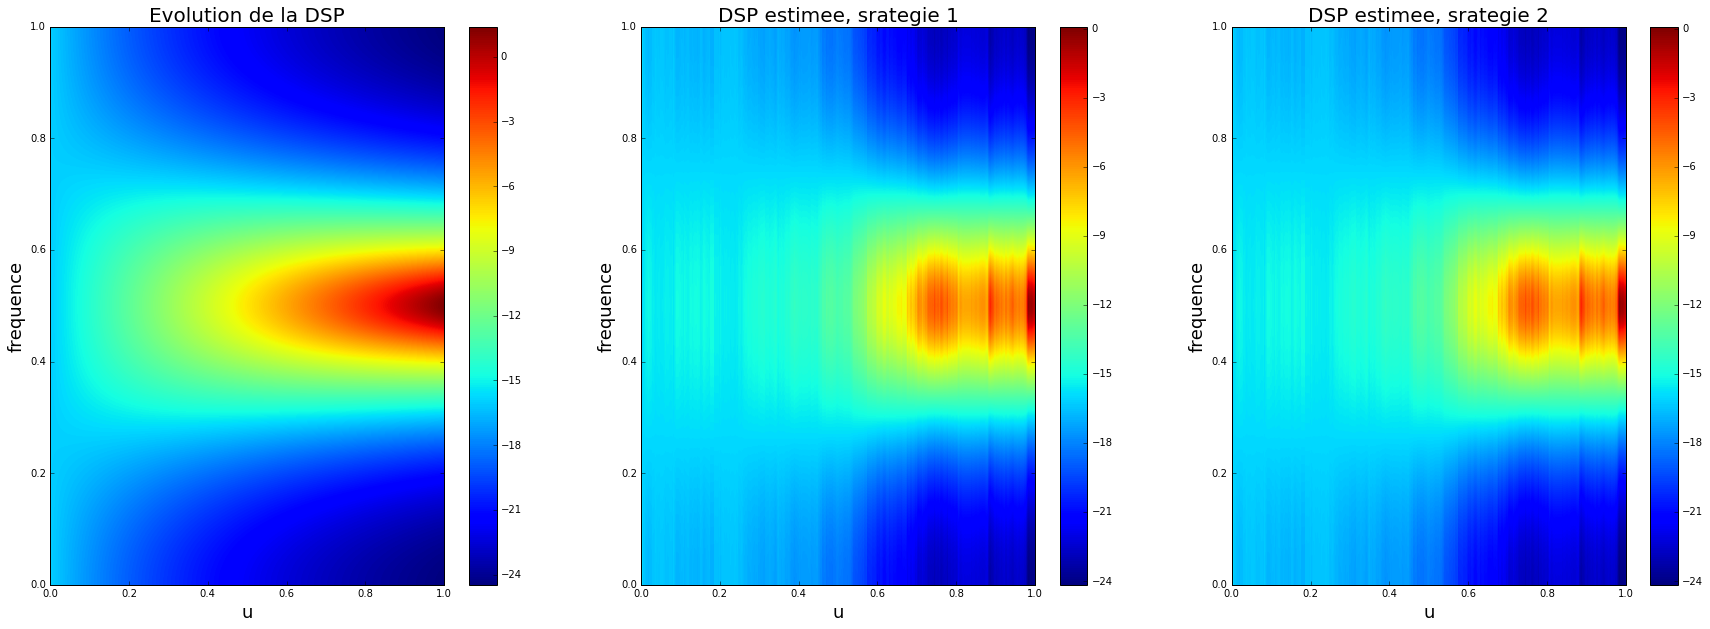

In [9]:
coeffs_est = np.ones((d+1,T),dtype='complex')
coeffs_est[1:,:] = -estim

coeffs_est2 = np.ones((d+1,T),dtype='complex')
coeffs_est2[1:,:] = -estim2

f, dsp_X_est = dsp(coeffs_est, T, Nfft)
f, dsp_X_est2 = dsp(coeffs_est2, T, Nfft)


fig,ax = plt.subplots(1,3,figsize=(30,10))
fsize=18
im=ax[0].imshow(20*np.log10(dsp_array),origin="lower", aspect="auto",extent=[0,1,0,1])
plt.colorbar(im,ax=ax[0])
ax[0].set_xlabel("u",fontsize=fsize)
ax[0].set_ylabel("frequence",fontsize=fsize)
ax[0].set_title("Evolution de la DSP",fontsize=fsize+2)

im2=ax[1].imshow(20*np.log10(dsp_X_est),origin="lower", aspect="auto",extent=[0,1,0,1])
plt.colorbar(im2,ax=ax[1])
ax[1].set_xlabel("u",fontsize=fsize)
ax[1].set_ylabel("frequence",fontsize=fsize)
ax[1].set_title("DSP estimee, srategie 1",fontsize=fsize+2)

im2=ax[2].imshow(20*np.log10(dsp_X_est2),origin="lower", aspect="auto",extent=[0,1,0,1])
plt.colorbar(im2,ax=ax[2])
ax[2].set_xlabel("u",fontsize=fsize)
ax[2].set_ylabel("frequence",fontsize=fsize)
ax[2].set_title("DSP estimee, srategie 2",fontsize=fsize+2)

plt.show()

## Cas où $\rho$ est constante

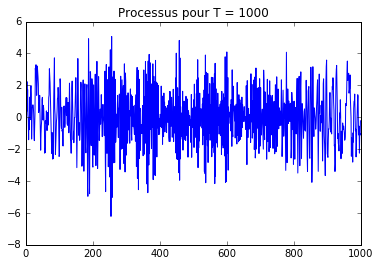

In [10]:
T = 1000
X = np.zeros(2*T, dtype='complex')
a = np.zeros(2*T, dtype='complex')

u = np.arange(T, dtype='double')/T

rho = 0.9
phase = u
phi = 2.*np.pi*phase

a[T:2*T] = rho*np.exp(1j*phi)

X[0] = epsilon[0]
    
for n in np.arange(2*T-1):
    X[n+1] = a[n+1]*X[n] + epsilon[n+1]
    
t = np.arange(2*T) - T #horizon des temps

plt.plot(t[T:2*T], np.real(X[T:2*T]))
plt.title("Processus pour T = 1000")

### Analyse spectrale théorique

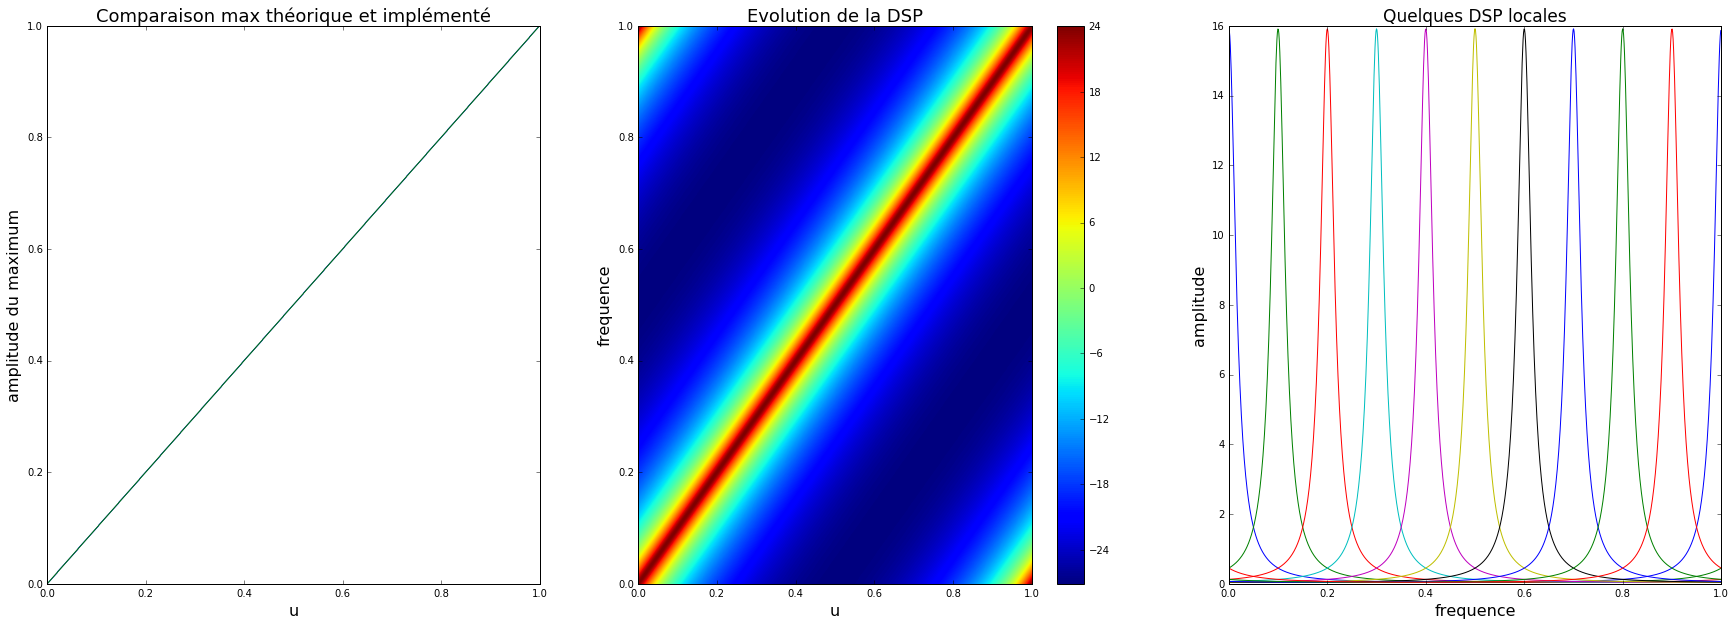

In [11]:
# Analyse spectrale
Nfft = 2**10
Theta = np.concatenate((np.ones((1,T),dtype='complex'),-a[T:2*T].reshape(1,T)),axis=0)
freq, dsp_array = dsp(Theta,T,Nfft)

freq = freq.reshape(Nfft,1)

max_pos = np.zeros(T)
for t in np.arange(T):
    max_pos[t] = freq[np.argmax(dsp_array[:,t])]


f,ax = plt.subplots(1,3,figsize=(30,10))
fsize=16
ax[0].plot(u, max_pos)
ax[0].plot(u, phase)
ax[0].set_xlabel("u",fontsize=fsize)
ax[0].set_ylabel("amplitude du maximum",fontsize=fsize)
ax[0].set_title("Comparaison max théorique et implémenté",fontsize=fsize+2)
    
im=ax[1].imshow(20*np.log10(dsp_array),origin="lower", aspect="auto",extent=[0,1,0,1])
plt.colorbar(im,ax=ax[1])
ax[1].set_xlabel("u",fontsize=fsize)
ax[1].set_ylabel("frequence",fontsize=fsize)
ax[1].set_title("Evolution de la DSP",fontsize=fsize+2)

ax[2].plot(freq, dsp_array[:,0::100])
ax[2].set_xlabel("frequence",fontsize=fsize)
ax[2].set_ylabel("amplitude",fontsize=fsize)
ax[2].set_title("Quelques DSP locales",fontsize=fsize+1)



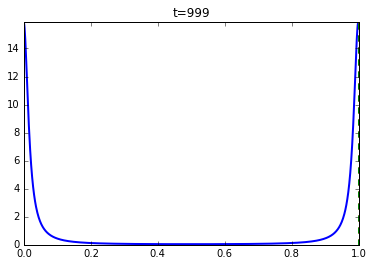

In [12]:
### Animation 
# Definition de la figure et des axes
fig = plt.figure()
ax = plt.axes(xlim=(0,1), ylim = (0,np.max(dsp_array)))
line, = ax.plot([], [], lw=2)
max_theo, = ax.plot([],[],'r--',lw=1) 
maximum, = ax.plot([],[],'g--',lw=1) 


# Fonction d'initialisation : affiche le fond à chaque étape
def init():
    line.set_data([], [])
    max_theo.set_data([],[])
    maximum.set_data([],[])
    return line, max_theo, maximum

# Fonction d'animation
def animate(t):
    line.set_data(freq, dsp_array[:,t])
    max_theo.set_data([phase[t],phase[t]],[0, np.max(dsp_array[:,t])])  
    maximum.set_data([max_pos[t],max_pos[t]],[0,np.max(dsp_array[:,t])])    
    ax.set_title("t=%d"%t)
    return line, max_theo, maximum

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=T, interval=1, blit=True)

anim.save('TVAR1_racine_phase.mp4',fps=150,extra_args=['-vcodec', 'libx264'])

### Estimation :

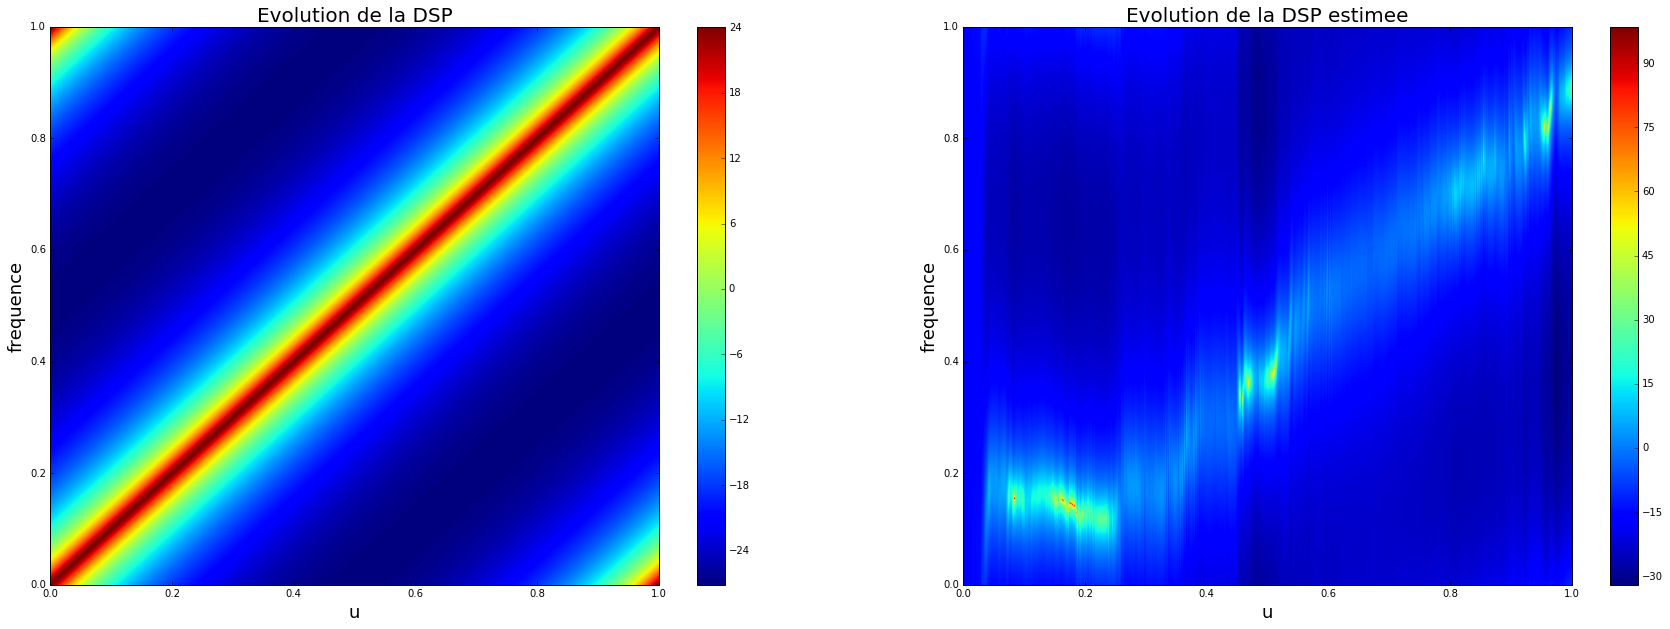

In [13]:
d=1
mu = 0.01
_, theta_est = generation_est2(X[T:2*T], d, T, mu)


coeffs_est = np.ones((d+1,T),dtype='complex')
coeffs_est[1:,:] = -theta_est 

f, dsp_X_est = dsp(coeffs_est, T, Nfft)

fig,ax = plt.subplots(1,2,figsize=(30,10))
fsize=18
im=ax[0].imshow(20*np.log10(dsp_array),origin="lower", aspect="auto",extent=[0,1,0,1])
plt.colorbar(im,ax=ax[0])
ax[0].set_xlabel("u",fontsize=fsize)
ax[0].set_ylabel("frequence",fontsize=fsize)
ax[0].set_title("Evolution de la DSP",fontsize=fsize+2)

im2=ax[1].imshow(20*np.log10(dsp_X_est),origin="lower", aspect="auto",extent=[0,1,0,1])
plt.colorbar(im2,ax=ax[1])
ax[1].set_xlabel("u",fontsize=fsize)
ax[1].set_ylabel("frequence",fontsize=fsize)
ax[1].set_title("Evolution de la DSP estimee",fontsize=fsize+2)

plt.show()


#### Agrégation

In [14]:
mu = np.arange(0.005,0.05,0.005)
N = len(mu)

pred, estim,_ = do_aggregation(X[T:2*T],d,T, 0.1, mu,1)
pred2, estim2,_ = do_aggregation(X[T:2*T], d, T, 0.1, mu,2)


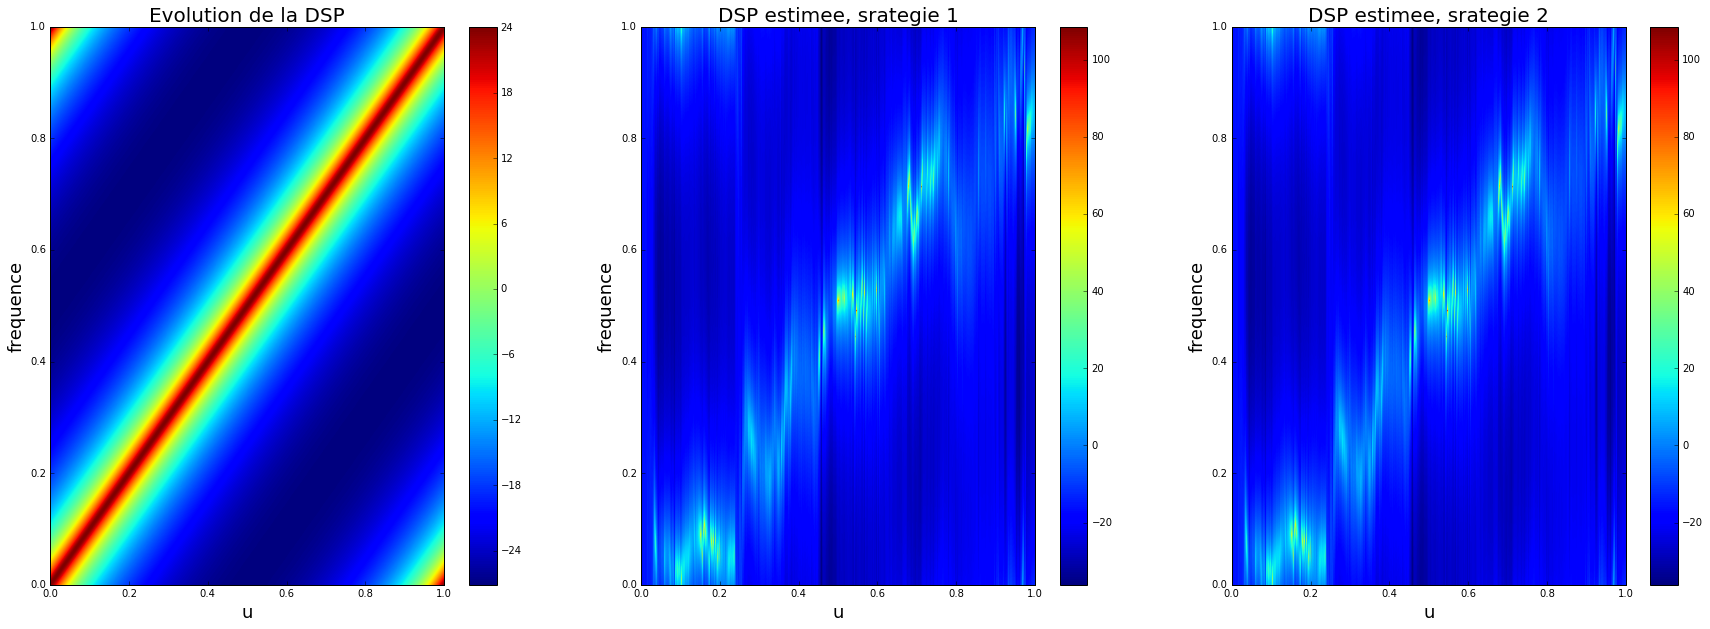

In [15]:
coeffs_est = np.ones((d+1,T),dtype='complex')
coeffs_est[1:,:] = -estim

coeffs_est2 = np.ones((d+1,T),dtype='complex')
coeffs_est2[1:,:] = -estim2

f, dsp_X_est = dsp(coeffs_est, T, Nfft)
f, dsp_X_est2 = dsp(coeffs_est2, T, Nfft)


fig,ax = plt.subplots(1,3,figsize=(30,10))
fsize=18
im=ax[0].imshow(20*np.log10(dsp_array),origin="lower", aspect="auto",extent=[0,1,0,1])
plt.colorbar(im,ax=ax[0])
ax[0].set_xlabel("u",fontsize=fsize)
ax[0].set_ylabel("frequence",fontsize=fsize)
ax[0].set_title("Evolution de la DSP",fontsize=fsize+2)

im2=ax[1].imshow(20*np.log10(dsp_X_est),origin="lower", aspect="auto",extent=[0,1,0,1])
plt.colorbar(im2,ax=ax[1])
ax[1].set_xlabel("u",fontsize=fsize)
ax[1].set_ylabel("frequence",fontsize=fsize)
ax[1].set_title("DSP estimee, srategie 1",fontsize=fsize+2)

im2=ax[2].imshow(20*np.log10(dsp_X_est2),origin="lower", aspect="auto",extent=[0,1,0,1])
plt.colorbar(im2,ax=ax[2])
ax[2].set_xlabel("u",fontsize=fsize)
ax[2].set_ylabel("frequence",fontsize=fsize)
ax[2].set_title("DSP estimee, srategie 2",fontsize=fsize+2)

plt.show()

# Exemple du TVAR(2)

Cette partie vise à présenter l'évolution d'un TVAR(2) en fonction du choix de T qui définit l'intervalle entre deux mesures du processus sur l'intervalle [0,1].

Rappelons que nous définissons le TVAR(2) comme suit $\forall t$ dans $[0,T]$:

\begin{equation}
X_{t,T} = a_1(\frac{t}{T})X_{t-1,T} + a_2(\frac{t}{T})X_{t-2,T} + \sigma(\frac{t}{T})\epsilon_{t,T}
\end{equation}

Avec $\epsilon_{t,T}$ un bruit blanc centré de variance 1.
Dans la suite, pour simplifier les expressions, on prendra $\sigma(u)=1$ sur $[0,1]$.

## Premier exemple : racines réelles

Prenons le polynôme caractéristique avec $\forall u$ dans $[0,1]$:
    \begin{equation}
    A(z;u) = 1 - a_1(u) z - a_2(u) z^2
    \end{equation}

Pour le cas $p=2$, il est facile de choisir des coefficients pour le TVAR puisqu'on a les relations coefficients/racines suivantes lorsque l'on note $z_1$ et $z_2$ les inverse des racines du polynome $1-a_1z - a_2z^2$:
\begin{equation}
a_1 = z_1 + z_2
\end{equation}
\begin{equation}
a_2 = -z_1 z_2
\end{equation}

Donc en choisissant les racines variant au cours du temps $u$ dans $[0,1]$ $z_1(u) = \frac{1}{2 + u}$ et $z_2(u) = \frac{1}{5 + \sin(2 \pi u)}$ (on vérifie bien la condition que $|z| < 1$), on a les coefficients : 

\begin{equation}
a_1(u) = \frac{7 + u+ \sin(2\pi u)}{(2 + u)(5 +\sin(2 \pi u))}
\end{equation}
\begin{equation}
a_2(u) = \frac{-1}{(2 + u)(5 + \sin(2 \pi u))}
\end{equation}

C:\Users\Amaury\Anaconda3\lib\site-packages\ipykernel\__main__.py:16: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\Amaury\Anaconda3\lib\site-packages\ipykernel\__main__.py:19: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


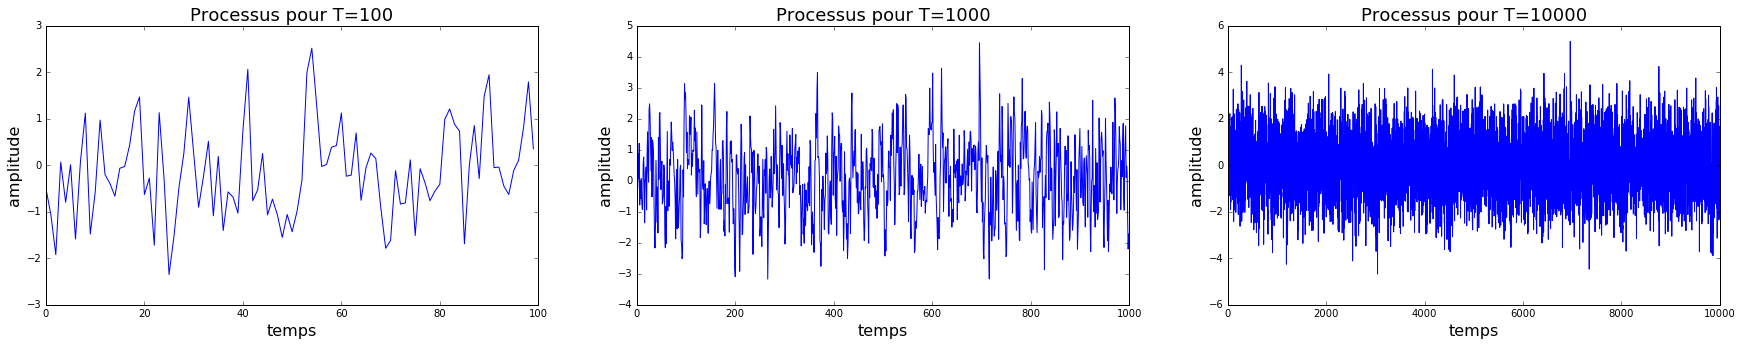

In [16]:
fig,ax = plt.subplots(1,3,figsize=(30,5))
k=0
fsize=16
for T in [100,1000,10000]:
    X = epsilon
    a_1 = np.zeros(2*T)
    a_2 = np.zeros(2*T)

    u = np.arange(T, dtype='double')/T

    a_1[T:2*T] =  (7 + u + np.sin(2 * np.pi * u)) / ((2 + u) * (5 + np.sin(2 * np.pi * u)))
    a_2[T:2*T] = - 1. / ((2 + u) * (5 + np.sin(2 * np.pi * u)))

    
    X[0] = epsilon[0]
    X[1] = epsilon[10000/T]
    
    for n in np.arange(2*T-2):
        X[n+2] = a_1[n+2]*X[n+1] + a_2[n+2]*X[n] + epsilon[(n+2)*10000/T]
    
    t = np.arange(2*T) - T #horizon des temps

    ax[k].plot(t[T:2*T], X[T:2*T])
    ax[k].set_xlabel("temps",fontsize=fsize)
    ax[k].set_ylabel("amplitude",fontsize=fsize)
    ax[k].set_title("Processus pour T=%s"%T,fontsize=fsize+2)
    
    k+=1
    

## Deuxième exemple : racines complexes conjuguées 

On s'intéresse maintenant au cas où les racines que l'on recherche sont complexes conjuguées.

Si on note $r = r_1 + ir_2$ l'inverse de l'une des deux racines, on a par les relations coefficients/racines que:
\begin{equation}
a_1 = 2Re(r)
\end{equation}
\begin{equation}
a_2 = -|r|^2
\end{equation}

### Premier cas : module constant, phase variable

On prend :
$$
r(u) = \rho e^{i\phi(u)}, \, 0 < \rho < 1, \phi(u) \in [-\pi,\pi[
$$
ce qui donne :
$$
a_1 = 2 \rho \cos(\phi(u))
$$
$$
a_2 = - \rho^2
$$

#### Construction pour T=1000

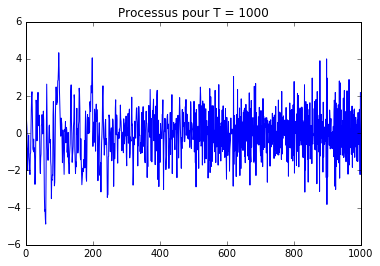

In [17]:
T = 1000
epsilon = np.random.randn(2*T)
X = np.zeros(2*T)
a_1 = np.zeros(2*T)
a_2 = np.zeros(2*T)

u = np.arange(T, dtype='double')/T

rho = 0.5
phase = u/2
phi = 2*np.pi*phase

a_1[T:2*T] = 2*rho*np.cos(phi)
a_2[T:2*T] = -rho**2


X[0] = epsilon[0]
X[1] = epsilon[1]
    
for n in np.arange(2*T-2):
    X[n+2] = a_1[n+2]*X[n+1] + a_2[n+2]*X[n] + epsilon[n+2]
    
t = np.arange(2*T) - T #horizon des temps

plt.plot(t[T:2*T], X[T:2*T])
plt.title("Processus pour T = 1000")

#### Analyse spectrale

In [18]:
# Analyse spectrale
Nfft = 2**10
Theta = np.concatenate((np.ones((1,T)),-a_1[T:2*T].reshape(1,T),-a_2[T:2*T].reshape(1,T)),axis=0)
freq, dsp_array = dsp(Theta,T,Nfft)

freq = freq.reshape(Nfft,)


In [19]:
max_pos = np.zeros(T)
for t in np.arange(T):
    #dsp_array[:,t] = dsp_array[:,t] / np.max(dsp_array[:,t])
    max_pos[t] = np.argmax(dsp_array[0:Nfft/2,t])

    
def max_theo(rho,phi):
    cas1 = (phi >= np.arccos(2*rho/(1+rho**2))) & (phi <= np.arccos(-2*rho/(1+rho**2)))
    cas2 = phi > np.arccos(-2*rho/(1+rho**2))
    val1 = cas1*np.arccos((1+rho**2)/(2*rho)*np.cos(phi))
    val2 = cas2*np.pi
    val1[np.isnan(val1)]=0
    return ((val1+val2)/(2*np.pi))
 

C:\Users\Amaury\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: RuntimeWarning: invalid value encountered in arccos


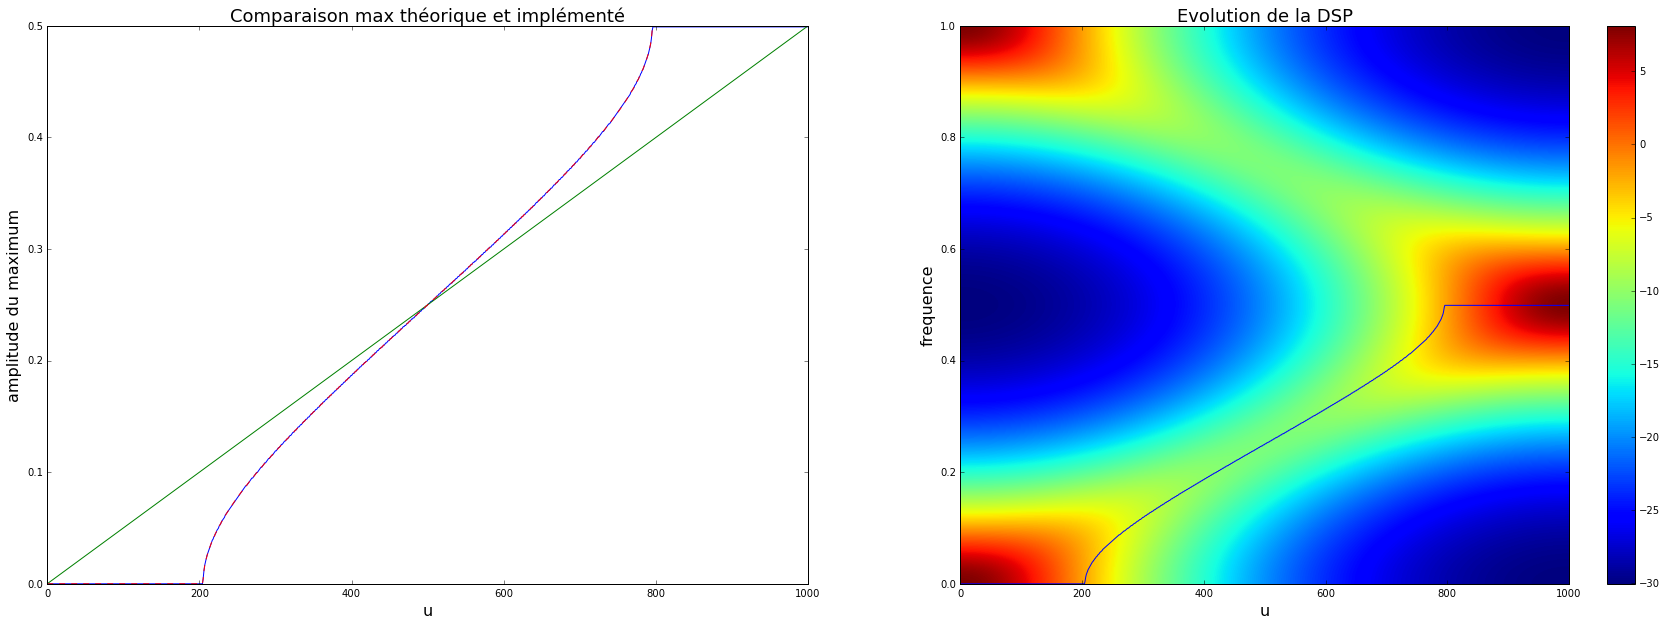

In [20]:
f,ax = plt.subplots(1,2,figsize=(30,10)) 
fsize=16
ax[0].plot(max_pos / Nfft)
ax[0].plot(phase)
ax[0].plot(max_theo(rho,phi),'r--')
ax[0].set_xlabel("u",fontsize=fsize)
ax[0].set_ylabel("amplitude du maximum",fontsize=fsize)
ax[0].set_title("Comparaison max théorique et implémenté",fontsize=fsize+2)
  
im=ax[1].imshow(20*np.log10(dsp_array),origin="lower", aspect="auto",extent=[0,T-1,0,1])
plt.colorbar(im,ax=ax[1])
ax[1].plot(max_pos / Nfft)
ax[1].set_xlabel("u",fontsize=fsize)
ax[1].set_ylabel("frequence",fontsize=fsize)
ax[1].set_title("Evolution de la DSP",fontsize=fsize+2)

#### Estimation :

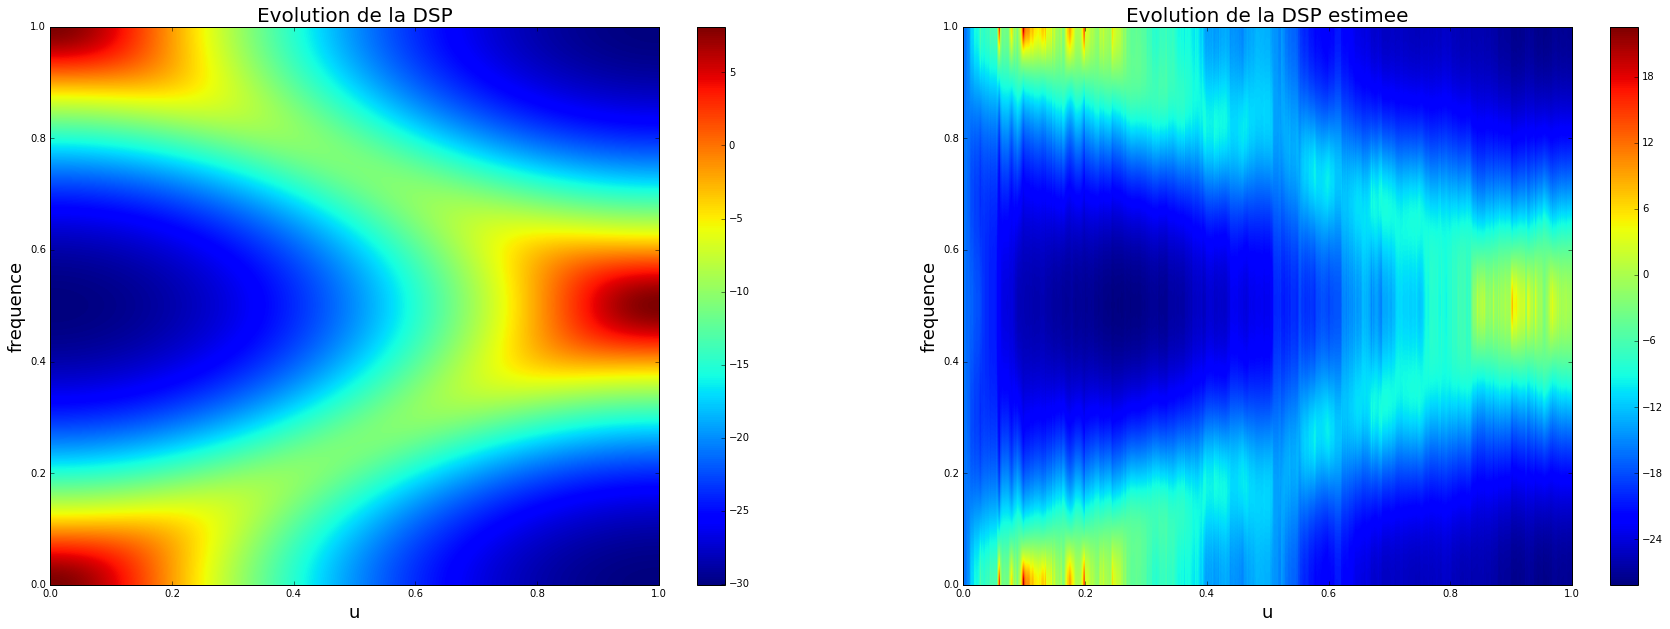

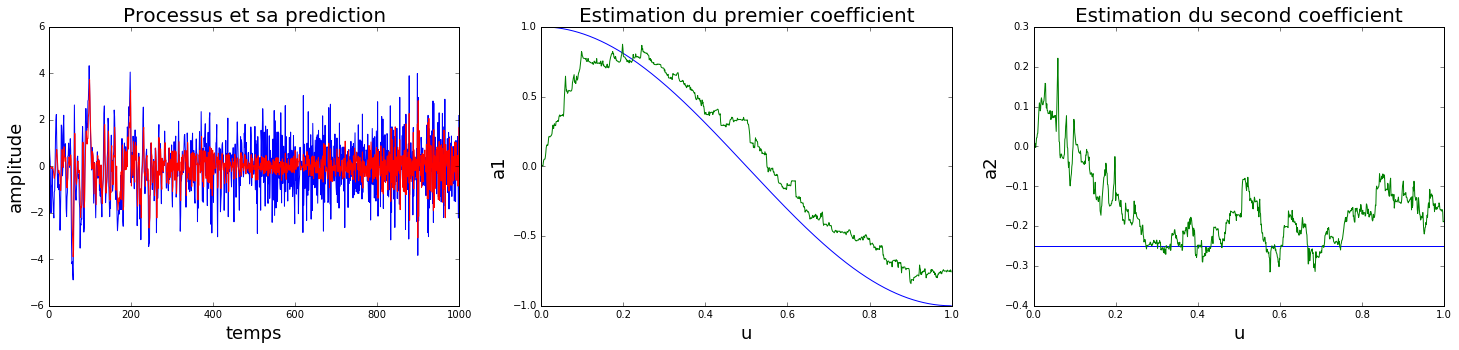

In [36]:
d=2
mu = 0.01
X_pred, theta_est = generation_est2(X[T:2*T], d, T, mu)


coeffs_est = np.ones((d+1,T),dtype='complex')
coeffs_est[1:,:] = -theta_est 

f, dsp_X_est = dsp(coeffs_est, T, Nfft)

fig,ax = plt.subplots(1,2,figsize=(30,10))
fsize=18
im=ax[0].imshow(20*np.log10(dsp_array),origin="lower", aspect="auto",extent=[0,1,0,1])
plt.colorbar(im,ax=ax[0])
ax[0].set_xlabel("u",fontsize=fsize)
ax[0].set_ylabel("frequence",fontsize=fsize)
ax[0].set_title("Evolution de la DSP",fontsize=fsize+2)

im2=ax[1].imshow(20*np.log10(dsp_X_est),origin="lower", aspect="auto",extent=[0,1,0,1])
plt.colorbar(im2,ax=ax[1])
ax[1].set_xlabel("u",fontsize=fsize)
ax[1].set_ylabel("frequence",fontsize=fsize)
ax[1].set_title("Evolution de la DSP estimee",fontsize=fsize+2)

plt.show()

plt.figure()
fig, ax = plt.subplots(1,3,figsize=(25,5))
ax[0].plot(np.real(X[T:]))
ax[0].plot(np.real(X_pred),'r')
ax[0].set_title("Processus et sa prediction",fontsize=fsize+2)
ax[0].set_xlabel("temps",fontsize=fsize)
ax[0].set_ylabel("amplitude",fontsize=fsize)

ax[1].plot(u,a_1[T:2*T])
ax[1].plot(u,np.real(theta_est[0,:]))
ax[1].set_title("Estimation du premier coefficient",fontsize=fsize+2)
ax[1].set_xlabel("u",fontsize=fsize)
ax[1].set_ylabel("a1",fontsize=fsize)

ax[2].plot(u,a_2[T:2*T])
ax[2].plot(u,np.real(theta_est[1,:]))
ax[2].set_title("Estimation du second coefficient",fontsize=fsize+2)
ax[2].set_xlabel("u",fontsize=fsize)
ax[2].set_ylabel("a2",fontsize=fsize)


#### Agrégation

In [22]:
log_mu = np.arange(-3, -2, 0.1)
N = len(log_mu)
mu = np.power(10, log_mu)
X_pred_all = np.zeros((N, T),dtype='complex')
theta_est_all = np.zeros((N, d,T),dtype='complex')
for k in np.arange(N):
    X_pred_all[k,:], theta_est_all[k,:,:] = generation_est2(X[T:2*T], d, T, mu[k])

pred, estim, alpha = aggregation(X[T:2*T], X_pred_all,theta_est_all, d,T, 0.1, 1)
pred2, estim2, alpha2 = aggregation(X[T:2*T], X_pred_all,theta_est_all, d, T, 0.1, 2)


In [23]:
log_mu = np.arange(-3, -2, 0.1)
N = len(log_mu)
mu = np.power(10, log_mu)

pred, estim,_ = do_aggregation(X[T:2*T],d,T, 0.1, mu,1)
pred2, estim2,_ = do_aggregation(X[T:2*T], d, T, 0.1, mu,2)

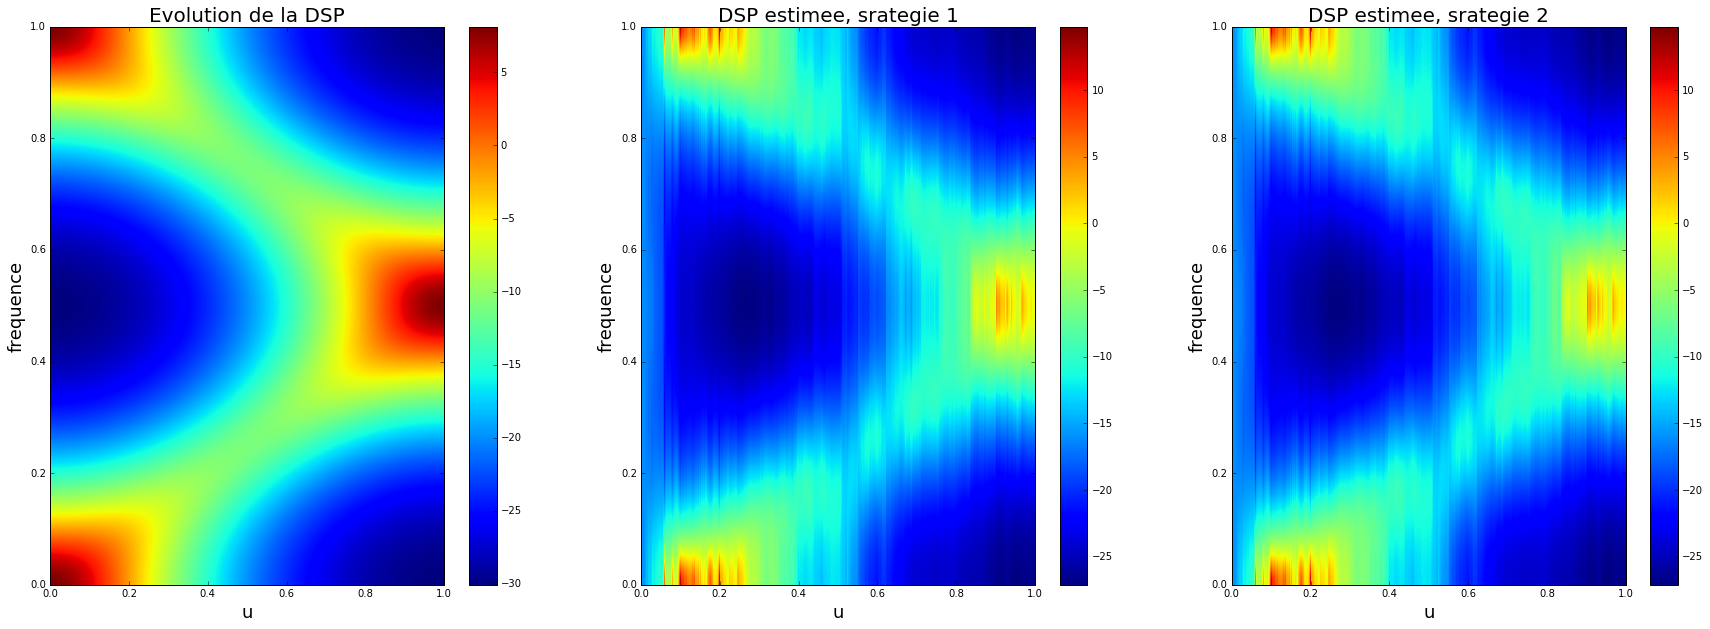

In [24]:
coeffs_est = np.ones((d+1,T),dtype='complex')
coeffs_est[1:,:] = -estim

coeffs_est2 = np.ones((d+1,T),dtype='complex')
coeffs_est2[1:,:] = -estim2

f, dsp_X_est = dsp(coeffs_est, T, Nfft)
f, dsp_X_est2 = dsp(coeffs_est2, T, Nfft)


fig,ax = plt.subplots(1,3,figsize=(30,10))
fsize=18
im=ax[0].imshow(20*np.log10(dsp_array),origin="lower", aspect="auto",extent=[0,1,0,1])
plt.colorbar(im,ax=ax[0])
ax[0].set_xlabel("u",fontsize=fsize)
ax[0].set_ylabel("frequence",fontsize=fsize)
ax[0].set_title("Evolution de la DSP",fontsize=fsize+2)

im2=ax[1].imshow(20*np.log10(dsp_X_est),origin="lower", aspect="auto",extent=[0,1,0,1])
plt.colorbar(im2,ax=ax[1])
ax[1].set_xlabel("u",fontsize=fsize)
ax[1].set_ylabel("frequence",fontsize=fsize)
ax[1].set_title("DSP estimee, srategie 1",fontsize=fsize+2)

im2=ax[2].imshow(20*np.log10(dsp_X_est2),origin="lower", aspect="auto",extent=[0,1,0,1])
plt.colorbar(im2,ax=ax[2])
ax[2].set_xlabel("u",fontsize=fsize)
ax[2].set_ylabel("frequence",fontsize=fsize)
ax[2].set_title("DSP estimee, srategie 2",fontsize=fsize+2)

plt.show()